# Property Data Preprocessing
This notebook will demonstrate the proprocessing of property data in the following sequence
1. **Data Combining**: combine `Domain data` (retrived from API) and `Old-listing data` (retrieved from webscraping)

2. **Filtering for Residential Property**: By the definition of residential property from Australia Taxation Office (ATO), A residential property includes houses, units, flats and more. It refers to residential property that provides shelter and contains basic living facilities. It doesn't include vacant land. Hence we will only be including the valid ones.

3. **Feature Preprocessing** We will be checking the validity of location(longitude and latitude), number of rooms (bedrooms, bathrooms, carparks), and weekly rent. 

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os 
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np

# caution: path[0] is reserved for script path (or '' in REPL)

sys.path.insert(1, '../../scripts/')
import historical7
from historical7 import prepro

import show_values
from show_values import show_values


## Data Combining
The preprocessing function will loop each raw file and they will be saved as curated data respectively.

In [72]:
path = "../../data/raw/historical_data/*.csv"
file_lst = []
for fname in glob.glob(path):
    file_lst.append(fname)

for file in file_lst:
    prepro(file, 'historical')

newpath = r'../../data/curated/property_all' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

../../scripts/historical7.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.dates = pd.to_datetime(df.historical_dates)
../../scripts/price.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weekly_rent'] = df2['weekly_rent'].str.extract('(\d+)').astype(int)
../../scripts/historical7.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.dates = pd.to_datetime(df.historical_dates)
../../scripts/price.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

After looping and preprocess through all historical data, we concatenate them into one dataframe and save them seperately base on year. 

In [73]:
curated_path = "../../data/raw/historical_data/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
combined_csv_raw = pd.concat([pd.read_csv(f) for f in file_lst2 ])
len1 = combined_csv_raw.shape[0]

In [74]:
curated_path = "../../data/curated/historical/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in file_lst2 ])
# run the following code if you want to generate a whole historical dataset. around 57MB. Thus, will not keep that in git for now.
# export to csv
# combined_csv.to_csv( "../../data/curated/historical/combined_historical.csv", index=False, encoding='utf-8-sig') 
len2 = combined_csv.shape[0]

In [75]:
drop = len1 - len2
print(f'{len1} data scraped from oldlisting website')
print(f'{drop} ({round((drop/len1)*100, 2)}%) duplicates & data with no rental price values were dropped from the web scrapped data.')
print(f'{len2} data remaining')

572580 data scraped from oldlisting website
232756 (40.65%) duplicates & data with no rental price values were dropped from the web scrapped data.
339824 data remaining


In [76]:
api_df_raw = pd.read_csv("../../data/raw/API_Raw_PropertiesInfo.csv")
api_df = pd.read_csv("../../data/curated/API_re_clean.csv")
len1 = api_df_raw.shape[0]
len2 = api_df.shape[0]
drop = len1 - len2
print(f'{len1} data from Domain API')
print(f'{drop} ({round((drop/len1)*100, 2)}%) duplicates & data with no rental price values were dropped from API retrieved data.')
print(f'{len2} data remaining')

15179 data from Domain API
483 (3.18%) duplicates & data with no rental price values were dropped from API retrieved data.
14696 data remaining


In [77]:
COLS = ['address', 'latitude', 'longitude', 'nbed', 'nbath',
       'ncar', 'price', 'type', 'historical_dates', 'postcode', 'year',
       'month', 'suburb', 'weekly_rent']
combined_csv = combined_csv[COLS]
api_df = api_df[COLS]
concat_df = pd.concat([combined_csv, api_df])
print(f'In total, we have {concat_df.shape[0]} instances, where {api_df.shape[0]} were from domain API and {combined_csv.shape[0]} were from oldlistings.com')

In total, we have 354520 instances, where 14696 were from domain API and 339824 were from oldlistings.com


In [78]:
concat_df.columns

Index(['address', 'latitude', 'longitude', 'nbed', 'nbath', 'ncar', 'price',
       'type', 'historical_dates', 'postcode', 'year', 'month', 'suburb',
       'weekly_rent'],
      dtype='object')

In [79]:
d = {'Number': [api_df.shape[0],combined_csv.shape[0]],
        'Source':['API','Web Scrapping']}
d_pd = pd.DataFrame(data = d)

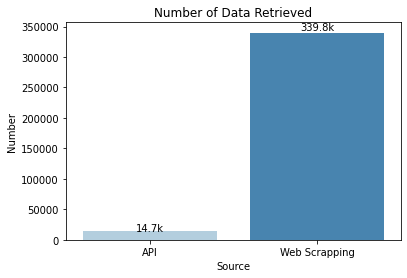

In [80]:
#plt.figure(figsize=(15,15))
ranks = d_pd.Number.sort_values().index

palette = sns.color_palette('Blues', len(ranks))
ax = sns.barplot(
    data=d_pd, x="Source", y="Number",palette=np.array(palette)
)

#ax.bar_label(ax.containers[0])
show_values(ax)

ax.set(title = "Number of Data Retrieved", ylabel = "Number", xlabel = "Source")
plt.savefig("../../plots/figure/Number of Data Retrieved.jpg")

In [81]:
for file in file_lst2:
    os.remove(file)

In [82]:
# os.remove("../../data/curated/historical/combined_historical.csv")

## Filtering Residential Properites

In [83]:
type_df = combined_csv[['type', 'year','weekly_rent','postcode']]\
        .groupby(['type'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

type_df

,type,averaged_wk_rent,num
0,- House,240.000000,1
1,2 Storey Unit,455.000000,1
2,Acreage,391.730769,52
3,Acreage Semi Rural,342.857143,7
4,Acreage Semi-rural,372.727273,11
...,...,...,...
69,Vacantland,353.333333,3
70,Villa,471.162896,442
71,"Villa, House",365.000000,1
72,"Villa, Unit, House",460.000000,1


In [84]:
list(type_df.type)

['- House',
 '2 Storey Unit',
 'Acreage',
 'Acreage Semi Rural',
 'Acreage Semi-rural',
 'Acreage/semi Rural',
 'Acreage/semi-rural',
 'Acreagesemi-rural',
 'Alpine',
 'Apartment',
 'Available',
 'Available Date',
 'Available Now',
 'Block Of Units',
 'Block Units',
 'Building',
 'Commercial',
 'Cottage',
 'Development',
 'Duplex',
 'Duplex Or Semi',
 'Duplex/semi Detach',
 'Duplexsemi',
 'Duplexsemi-detached',
 'Farm',
 'Flat',
 'Flat, Block Of Units',
 'Holiday',
 'Holiday, Rural',
 'Home Unit',
 'Hotel/leisure',
 'House',
 'House-on-acreage',
 'Houseland',
 'Houses',
 'Industrial/warehouse',
 'Land',
 'Land, House',
 'Lifestyle',
 'Lifestyle With House',
 'Medical/consulting',
 'Offices',
 'Other',
 'Rental',
 'Rental Property',
 'Rental_residential',
 'Residential',
 'Residential Home',
 'Residential House',
 'Residential Lease',
 'Residential Rentals',
 'Rural',
 'Rural / Farm',
 'Rural/farm',
 'Rural/farm/acreage',
 'Semi',
 'Semi Detached',
 'Semi-detached',
 'Semi-detached/dupl

### residential type simple classification
We will classify residential types into house, apartment, and other. For the 'other' type, we assume they are residential properties as there is a large amount of them (around 20% of the whole dataset), and we saw that most of them are residential properties when doing web scraping.

In [85]:
house_lst = [
    '- House',
    'Cottage',
    'Duplex',
    'Duplex Or Semi',
    'Duplex/semi Detach',
    'Duplexsemi',
    'Duplexsemi-detached',
    'House',
    'Houses',
    'Residential House',
    'Semi',
    'Semi Detached',
    'Semi-detached',
    'Semi-detached/duplex',
    'Semi-detatched',
    'Semi-duplex',
    'Townhouse',
    'Villa',
    'Villa, House',
    'Villa, Unit, House',
    ]

In [86]:
apt_lst = [
 '2 Storey Unit',
 'Apartment',
 'Block Of Units',
 'Block Units',
  'Flat',
 'Flat, Block Of Units',
 'Home Unit',
 'Studio',
 'Unit',
]

In [87]:
other_residential_lst = [
 'Available',
 'Available Now',
 'Rental',
 'Rental Property',
 'Rental_residential',
 'Residential',
 'Residential Home',
 'Residential House',
 'Residential Lease',
 'Residential Rentals',
 'none']

In [88]:
all_lst = house_lst + apt_lst + other_residential_lst
all_lst

['- House',
 'Cottage',
 'Duplex',
 'Duplex Or Semi',
 'Duplex/semi Detach',
 'Duplexsemi',
 'Duplexsemi-detached',
 'House',
 'Houses',
 'Residential House',
 'Semi',
 'Semi Detached',
 'Semi-detached',
 'Semi-detached/duplex',
 'Semi-detatched',
 'Semi-duplex',
 'Townhouse',
 'Villa',
 'Villa, House',
 'Villa, Unit, House',
 '2 Storey Unit',
 'Apartment',
 'Block Of Units',
 'Block Units',
 'Flat',
 'Flat, Block Of Units',
 'Home Unit',
 'Studio',
 'Unit',
 'Available',
 'Available Now',
 'Rental',
 'Rental Property',
 'Rental_residential',
 'Residential',
 'Residential Home',
 'Residential House',
 'Residential Lease',
 'Residential Rentals',
 'none']

In [89]:
concat_df.type

0                    House
1                    House
2        Residential Lease
3        Residential Lease
4        Residential Lease
               ...        
14691                 Rent
14692                 Rent
14693                 Rent
14694                 Rent
14695                 Rent
Name: type, Length: 354520, dtype: object

In [90]:
residential_df = concat_df[concat_df['type'].isin(all_lst)]
print(f'{len(concat_df)-len(residential_df)} instances were dropped as they were not residential rental properties, {len(residential_df)} instances were left.')

72168 instances were dropped as they were not residential rental properties, 282352 instances were left.


In [91]:
import numpy as np
#df = residential_df
conditions = [
    (residential_df['type'].isin(house_lst)),
    (residential_df['type'].isin(apt_lst)),
    (residential_df['type'].isin(other_residential_lst)),
    ]
values = ['House', 'Apartment', 'Other']
residential_df['residence_type'] = np.select(conditions, values)
residential_df.head()

<ipython-input-91-ca841eeed4fd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residential_df['residence_type'] = np.select(conditions, values)


,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
0,"231 MAIN ROAD, CHEWTON",-37.080966,144.265555,2.0,1.0,3,$380_per_week,House,March 2022,3451,2022,3,CHEWTON,380,House
1,"231 MAIN ROAD, CHEWTON",-37.080966,144.265555,2.0,1.0,3,$380_per_week,House,February 2022,3451,2022,2,CHEWTON,380,House
2,"108 ADELAIDE STREET, CHEWTON",-37.093186,144.254132,2.0,1.0,2,$340_per_week,Residential Lease,November 2021,3451,2021,11,CHEWTON,340,Other
3,"108 ADELAIDE STREET, CHEWTON",-37.093186,144.254132,2.0,1.0,2,$330_pw,Residential Lease,June 2020,3451,2020,6,CHEWTON,330,Other
4,"108 ADELAIDE STREET, CHEWTON",-37.093186,144.254132,2.0,1.0,2,$250_pw,Residential Lease,October 2010,3451,2010,10,CHEWTON,250,Other


In [92]:
YEARS = []
for i in range(2006,2023):
    YEARS.append(i)
YEARS
for year in YEARS:
    df = residential_df[residential_df.year == year]
    df.to_csv(f'../../data/curated/property_all/{year}_historical_clean.csv')

#### further visual checking after only keeping rental residential properties

In [93]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np

In [94]:
curated_path = "../../data/curated/property_all/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
residential_df = pd.concat([pd.read_csv(f) for f in file_lst2 ])

In [95]:
type_df2 = residential_df[['residence_type', 'year','weekly_rent','postcode']]\
        .groupby(['residence_type'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

type_df2

,residence_type,averaged_wk_rent,num
0,Apartment,384.902496,11220
1,House,486.828051,147404
2,Other,471.272477,123728


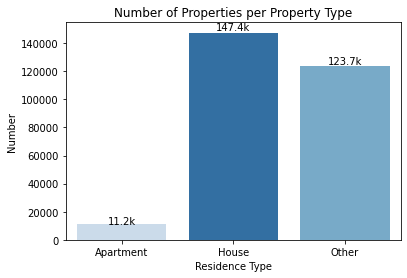

In [96]:
#plt.figure(figsize=(15,15))
ranks = type_df2.num.rank().sub(1).astype(int).array
palette = sns.color_palette('Blues', len(ranks))
ax = sns.barplot(
    data=type_df2, x="residence_type", y="num", palette=np.array(palette)[ranks]
)
#ax.bar_label(ax.containers[0])
show_values(ax)
ax.set(title = "Number of Properties per Property Type", ylabel = "Number", xlabel = "Residence Type")
plt.savefig("../../plots/figure/Number of Properties per Property Type.jpg")


## Preprocessing Features
### Locations

In [97]:
residential_df.longitude.astype(str).str.len().describe()

count    282352.000000
mean         10.513572
std           1.203985
min           5.000000
25%          10.000000
50%          10.000000
75%          11.000000
max          18.000000
Name: longitude, dtype: float64

In [98]:
residential_df.latitude.astype(str).str.len().describe()

count    282352.000000
mean         10.513033
std           1.292038
min           5.000000
25%          10.000000
50%          10.000000
75%          11.000000
max         158.000000
Name: latitude, dtype: float64

In [99]:
residential_df[residential_df.longitude.astype(str).str.len() == 18]

,Unnamed: 0,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
1541,6526,"5 SPRING STREET, COBURG",-37.887524,145.293916,3.0,1.0,6,$600_per_week,House,August 2022,3058,2022,8,COBURG,600,House
1542,6527,"5 SPRING STREET, COBURG",-37.887524,145.293916,3.0,1.0,6,$500,House,August 2022,3058,2022,8,COBURG,500,House
1543,6528,"5 SPRING STREET, COBURG",-37.887524,145.293916,3.0,1.0,6,$600_per_week,House,July 2022,3058,2022,7,COBURG,600,House
1939,7893,"1 EDWARD STREET, COBURG",-37.912922,145.348387,2.0,1.0,3,$480_per_week,Rental_residential,June 2022,3058,2022,6,COBURG,480,Other
1940,7894,"1 EDWARD STREET, COBURG",-37.912922,145.348387,2.0,1.0,3,$500_per_week,Rental_residential,June 2022,3058,2022,6,COBURG,500,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16233,5950,"9 ALBANY WAY, CHARLEMONT",-38.210577,144.364416,3.0,2.0,2,$430_per_week,House,September 2021,3217,2021,9,CHARLEMONT,430,House
21063,767,"2/23 CANONBURY CIRCLE, SEABROOK",-37.881046,144.760212,2.0,1.0,1,$330_per_week,House,December 2021,3028,2021,12,SEABROOK,330,House
21691,2873,"2 STEWART CL, KEALBA",-37.737285,144.828972,4.0,2.0,4,$470,Rental_residential,December 2021,3021,2021,12,KEALBA,470,Other
26320,3395,"3, 46-54 GOWANBRAE DRIVE, GOWANBRAE",-37.709039,144.889270,3.0,2.0,1,$380_per_week,Townhouse,December 2021,3043,2021,12,GOWANBRAE,380,House


In [100]:
residential_df[residential_df.latitude.astype(str).str.len() == 158]

,Unnamed: 0,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
1718,3013,"1 ""BUNDARA 1"" BURRINJUCK LANE, DINNER PLAIN","-36.8826280"" data-lng=""147.0562333""> <section ...",147.056233,3.0,2.0,0,$385_per_week,Townhouse,December 2011,3898,2011,12,PLAIN,385,House
2342,3012,"1 ""BUNDARA 1"" BURRINJUCK LANE, DINNER PLAIN","-36.8826280"" data-lng=""147.0562333""> <section ...",147.056233,3.0,2.0,0,$385_per_week,Townhouse,May 2012,3898,2012,5,PLAIN,385,House
2343,3014,"1 ""BUNDARA 2"" BURRINJUCK LANE, DINNER PLAIN","-36.8826280"" data-lng=""147.0562333""> <section ...",147.056233,3.0,2.0,0,$385_per_week,Townhouse,May 2012,3898,2012,5,PLAIN,385,House


In [101]:
old_value = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[0]
old_value1 = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[1]
old_value2 = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[2]
new_value = '-36.8826280'
residential_df['latitude'] = residential_df['latitude'].replace([old_value],new_value)
residential_df['latitude'] = residential_df['latitude'].replace([old_value1],new_value)
residential_df['latitude'] = residential_df['latitude'].replace([old_value2],new_value)


In [102]:
residential_df.latitude.astype(str).str.len().describe()

count    282352.000000
mean         10.511471
std           1.199267
min           5.000000
25%          10.000000
50%          10.000000
75%          11.000000
max          19.000000
Name: latitude, dtype: float64

In [103]:
residential_df[residential_df.latitude.astype(str).str.len() == 19]

,Unnamed: 0,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
4469,206,"72/99 SPRING STREET, MELBOURNE",-37.731801,145.000476,3.0,2.0,1,$1400_per_week,none,September 2022,3000,2022,9,MELBOURNE,1400,Other
12044,2604,"4 MERTON PLACE, ALBERT PARK",-37.844642,144.954529,2.0,1.0,0,$800_per_week,House,February 2022,3206,2022,2,PARK,800,House
19766,3101,"37 NOLAN STREET, NORTH BENDIGO",-36.746154,144.285681,3.0,1.0,2,$430_per_week,none,August 2022,3550,2022,8,BENDIGO,430,Other
19787,3152,"83 NOLAN STREET, NORTH BENDIGO",-36.746154,144.285681,3.0,1.0,2,$390,Available Now,August 2022,3550,2022,8,BENDIGO,390,Other
19985,4768,"E23/140 ARDEN STREET, NORTH MELBOURNE",-37.801269,144.951519,3.0,1.0,0,$430_pw,Unit,August 2022,3051,2022,8,MELBOURNE,430,Apartment
19986,4769,"E23/140 ARDEN STREET, NORTH MELBOURNE",-37.801269,144.951519,3.0,1.0,0,$430_pw,Unit,April 2022,3051,2022,4,MELBOURNE,430,Apartment
19987,4770,"E23/140 ARDEN STREET, NORTH MELBOURNE",-37.801269,144.951519,3.0,1.0,0,$410_pw,Unit,April 2022,3051,2022,4,MELBOURNE,410,Apartment
20184,5756,"G19/23 BLACKWOOD STREET, NORTH MELBOURNE",-37.801163,144.955015,2.0,1.0,0,$500_per_week,Available,July 2022,3051,2022,7,MELBOURNE,500,Other
21059,952,"1071 HIGH STREET, RESERVOIR",-37.697947,145.010699,3.0,1.0,8,$580_Weekly,House,September 2022,3073,2022,9,RESERVOIR,580,House
21060,953,"1071 HIGH STREET, RESERVOIR",-37.697947,145.010699,3.0,1.0,8,$580,House,July 2022,3073,2022,7,RESERVOIR,580,House


### Number of Rooms

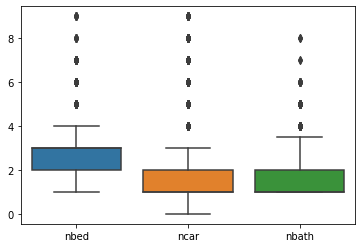

In [104]:
ax = sns.boxplot(data=residential_df[['nbed','ncar','nbath']])

In [105]:
residential_df[residential_df.nbath > 5]

,Unnamed: 0,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
3850,2181,"RM 6/6 CORRIGAN ST, BURWOOD",-37.854216,145.111499,8.0,6.0,4,$190,Rental_residential,August 2022,3125,2022,8,BURWOOD,190,Other
17732,1175,"2/10 BLACK STREET, OAKLEIGH EAST",-37.91268,145.119540,6.0,6.0,2,$850_per_week,House,June 2022,3166,2022,6,EAST,850,House
17735,1179,"2/10 BLACK ST, OAKLEIGH EAST",-37.912445,145.119795,6.0,6.0,2,$850_per_week,House,June 2022,3166,2022,6,EAST,850,House
25412,1828,"46 CHAUCER CRESCENT, CANTERBURY",-37.824598,145.076118,5.0,7.0,5,$4000_per_week,Rental_residential,August 2022,3126,2022,8,CANTERBURY,4000,Other
27042,10724,"15 GARRETY ROAD, CAROLINE SPRINGS",-37.731142,144.746371,6.0,6.0,2,$600_per_week,House,July 2022,3023,2022,7,SPRINGS,600,House
40603,2188,"5 OAKS COURT, LYSTERFIELD SOUTH",-37.960606,145.284575,4.0,6.0,4,$1500,Rental_residential,August 2022,3156,2022,8,SOUTH,1500,Other
57274,2903,"29 BOUNDARY ROAD, LILYDALE",-37.74476,145.407529,6.0,8.0,6,$950_pw,none,July 2022,3140,2022,7,LILYDALE,950,Other
57275,2904,"29 BOUNDARY ROAD, LILYDALE",-37.74476,145.407529,6.0,8.0,6,$950_pw,none,June 2022,3140,2022,6,LILYDALE,950,Other
65937,3093,"1 MOLESWORTH ST, KEW",-37.800309,145.020626,6.0,6.0,4,$4500_pw,none,August 2022,3101,2022,8,KEW,4500,Other
67319,1060,"4511 FRANKSTON-FLINDERS ROAD, FLINDERS",-38.46039,145.021240,6.0,6.0,2,$4800_per_week,House,June 2022,3929,2022,6,FLINDERS,4800,House


double check:

https://www.realestate.com.au/property/47-barber-st-pyramid-hill-vic-3575

For '47 BARBER STREET, PYRAMID HILL' since the rental price is relatively low, for this property, we google for confirmation. From google, we can tell the number of bathroom for this property is 1.0.

https://www.domain.com.au/rm-6-6-corrigan-st-burwood-vic-3125-8539197

This one suggests that 'RM 6/6 CORRIGAN ST, BURWOOD' is not oulier with large number of rooms and low price.

In [106]:
residential_df.loc[residential_df['address'] == '47 BARBER STREET, PYRAMID HILL' , 'nbath'] = 1

In [107]:
residential_df.loc[residential_df['address'] == '47 BARBER STREET, PYRAMID HILL']
# after removing this, we can see that the number of bedrroms are also large hence we assume there's no outliers for nbed and nbath

,Unnamed: 0,address,latitude,longitude,nbed,nbath,ncar,price,type,historical_dates,postcode,year,month,suburb,weekly_rent,residence_type
7141,9006,"47 BARBER STREET, PYRAMID HILL",-36.059997,144.114142,3.0,1.0,0,$145_pw,none,November 2011,3575,2011,11,HILL,145,Other


### Weekly rent
#### 2013 as example

In [108]:
df_2013 = residential_df[residential_df.year == 2013]

In [109]:
COLS = ['address','type','weekly_rent','postcode','nbed','nbath','ncar','residence_type']

In [110]:
df_2013 = df_2013[COLS]
df_2013

,address,type,weekly_rent,postcode,nbed,nbath,ncar,residence_type
0,"208 MAIN ROAD, CHEWTON",House,300,3451,3.0,1.0,2,House
1,"171 MAIN ROAD, CHEWTON",House,330,3451,3.0,1.0,8,House
2,"173 MAIN ROAD, CHEWTON",House,270,3451,2.0,1.0,0,House
3,"173 MAIN ROAD, CHEWTON",House,270,3451,2.0,1.0,0,House
4,"4 GEORGE STREET, CHEWTON",House,350,3451,3.0,1.0,2,House
...,...,...,...,...,...,...,...,...
11834,"7 BENNETT STREET, YINNAR",House,340,3869,4.0,2.0,1,House
11835,"7 BENNETT STREET, YINNAR",House,300,3869,4.0,2.0,1,House
11836,"7 BENNETT STREET, YINNAR",House,340,3869,4.0,2.0,1,House
11837,"7 BENNETT STREET, YINNAR",House,350,3869,4.0,2.0,1,House


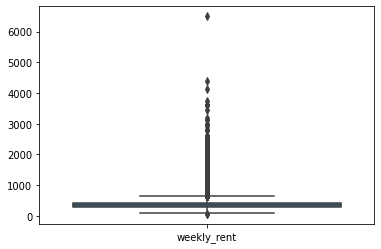

In [111]:
ax = sns.boxplot(data=df_2013[['weekly_rent']])

In [112]:
df_2013[df_2013['weekly_rent'] > 3000]

,address,type,weekly_rent,postcode,nbed,nbath,ncar,residence_type
685,"102/8 BLIGH PLACE, MELBOURNE",Available Now,4127,3000,2.0,2.0,2,Other
4252,"4/57 ASLING STREET, BRIGHTON",none,4400,3186,2.0,1.0,1,Other
4812,"15 RICHARD STREET, WILLIAMSTOWN",Available Now,3737,3016,3.0,2.0,1,Other
5146,"37 MURRAY DRIVE, POINT LEO",none,3600,3916,3.0,2.0,2,Other
5147,"37 MURRAY DRIVE, POINT LEO",none,3600,3916,3.0,2.0,2,Other
6718,"2 DRAKE STREET, MORNINGTON",none,3120,3931,5.0,3.0,2,Other
6728,"55 BELEURA HILL ROAD, MORNINGTON",House,6500,3931,4.0,4.0,2,House
7120,"535 GREAT OCEAN ROAD, MOGGS CREEK",none,3200,3231,4.0,2.0,0,Other
8918,"30 SHOREHAM ROAD, SHOREHAM",none,3600,3916,4.0,2.0,0,Other
8919,"30 SHOREHAM ROAD, SHOREHAM",none,3600,3916,4.0,2.0,0,Other


The mentioned above instances are all outliers. Hence, we consider removing values outsided of 3 standard devisation.

102/8 Bligh Place, Melbourne, Vic 3000: $890 per week in 2022: https://www.realestate.com.au/property-apartment-vic-melbourne-429072318

15 RICHARD STREET, WILLIAMSTOWN: $1,100pw in 2022: https://www.homely.com.au/homes/15-richard-street-williamstown-vic-3016/5250272

37 Murray Drive: $654 pw in 2022: https://www.propertyvalue.com.au/property/37-murray-drive-point-leo-vic-3916/12541662

2 Drake Street, Mornington VIC 3931: $1,525PER WEEK in 2022: https://www.domain.com.au/property-profile2-drake-street-mornington-vic-3931

55 BELEURA HILL ROAD, MORNINGTON: $1500.00 pw in 2022: https://www.homely.com.au/homes/55-beleura-hill-road-mornington-vic-3931/1269977

535 Great Ocean Road Moggs Creek VIC 3231: $552 pw in 2022: https://www.propertyvalue.com.au/property/535-great-ocean-road-moggs-creek-vic-3231/11874101

30 Shoreham Road Shoreham VIC 3916: $850/w in 2022: https://www.onthehouse.com.au/property/vic/shoreham-3916/30-shoreham-rd-shoreham-vic-3916-8066322

148 BROUGHAM STREET, KEW: $995.00 per week in 2022: https://www.domain.com.au/148-brougham-street-kew-vic-3101-15300836


In [113]:
import numpy as np
from scipy import stats

In [114]:
df_2013_rent = df_2013[(np.abs(stats.zscore(df_2013.weekly_rent)) < 3)]
print(f'{len(df_2013) - len(df_2013_rent)} instances were dropped from {len(df_2013)}, {len(df_2013_rent)} remaining')

270 instances were dropped from 11839, 11569 remaining


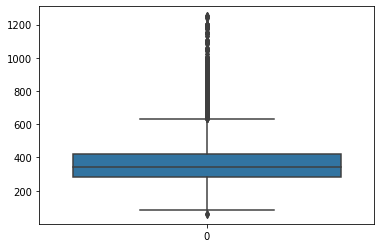

In [115]:
ax = sns.boxplot(data=df_2013_rent.weekly_rent)

#### 2014 as example

In [116]:
df_2014 = residential_df[residential_df.year == 2014]

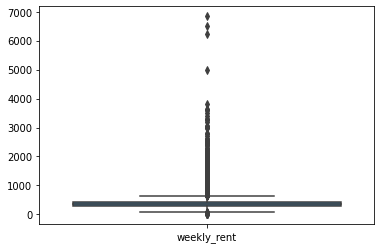

In [117]:
ax = sns.boxplot(data=df_2014[['weekly_rent']])

In [118]:
df_2014_rent = df_2014[(np.abs(stats.zscore(df_2014.weekly_rent)) < 3)]
print(f'{len(df_2014) - len(df_2014_rent)} ({round((len(df_2014) - len(df_2014_rent))/len(df_2014)*100,2)}%) instances were dropped from {len(df_2014)}, {len(df_2014_rent)} remaining')

251 (1.96%) instances were dropped from 12789, 12538 remaining


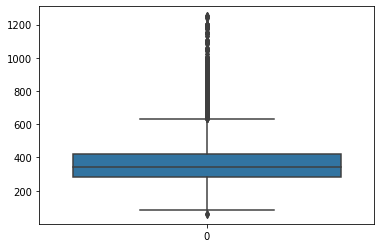

In [119]:
ax = sns.boxplot(data=df_2013_rent.weekly_rent)

#### Preprocess rent for all
As approaches for rental outliers detection is quite are quite similar, we apply a function for this.

In [120]:
sys.path.insert(1, '../../scripts/')
import outlier_drop_
from outlier_drop_ import outlier_removal

In [121]:
for year in YEARS:
    df = residential_df[residential_df.year ==year]
    df.to_csv(f'../../data/curated/property_all/{str(year)}_historical_clean.csv')

In [122]:
curated_path = "../../data/curated/property_all/*.csv"
property_all_lst = []
for fname in glob.glob(curated_path):
    property_all_lst.append(fname)


# combine all files in the list
combined_csv_withoutlier = pd.concat([pd.read_csv(f) for f in property_all_lst ])
print(f'{combined_csv_withoutlier.shape[0]} data before outlier removal')

282352 data before outlier removal


In [123]:
property_all_lst = sorted(property_all_lst)

In [124]:
for path in property_all_lst:
    outlier_removal(path)

2006: 11 (2.1%) instances were dropped from 523, 512 remaining
2007: 75 (1.59%) instances were dropped from 4708, 4633 remaining
2008: 98 (1.78%) instances were dropped from 5494, 5396 remaining
2009: 94 (1.82%) instances were dropped from 5172, 5078 remaining
2010: 99 (1.59%) instances were dropped from 6232, 6133 remaining
2011: 135 (1.53%) instances were dropped from 8815, 8680 remaining
2012: 200 (1.8%) instances were dropped from 11117, 10917 remaining
2013: 270 (2.28%) instances were dropped from 11839, 11569 remaining
2014: 251 (1.96%) instances were dropped from 12789, 12538 remaining
2015: 260 (1.97%) instances were dropped from 13188, 12928 remaining
2016: 340 (2.18%) instances were dropped from 15606, 15266 remaining
2017: 420 (2.37%) instances were dropped from 17751, 17331 remaining
2018: 443 (2.18%) instances were dropped from 20320, 19877 remaining
2019: 549 (2.45%) instances were dropped from 22400, 21851 remaining
2020: 607 (2.69%) instances were dropped from 22594, 21

In [125]:
#import pandas as pd
#import glob

curated_path = "../../data/curated/property_all_with_SA2/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in file_lst2 ])
#combined_csv.to_csv("total_property.csv")

In [126]:
outlier_rem = combined_csv.shape[0]
print(outlier_rem)

231497


In [127]:
outlier_rem = combined_csv.shape[0]
outlier_no_rem = concat_df.shape[0]
print(f'{outlier_no_rem - outlier_rem} ({round((outlier_no_rem - outlier_rem) *100/outlier_no_rem,2)}%) outliers were removed in total, ')

123023 (34.7%) outliers were removed in total, 


In [128]:
year_df = combined_csv[['type', 'year','weekly_rent','postcode']]\
        .groupby(['year'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

year_df

,year,averaged_wk_rent,num
0,2013,365.443223,11466
1,2014,372.474818,12489
2,2015,379.335550,12782
3,2016,385.154309,15119
4,2017,405.824185,17143
5,2018,424.024689,19604
6,2019,433.963905,21554
7,2020,470.199279,21638
8,2021,482.558225,26595
9,2022,505.979537,73107


In [129]:
print(f'in total {sum(year_df.num)} instances after cleaning ')

in total 231497 instances after cleaning 


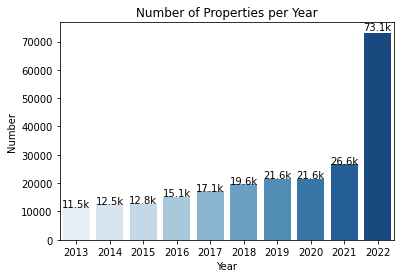

In [130]:
ranks = year_df.num.rank().sub(1).astype(int).array
palette = sns.color_palette('Blues', len(ranks))
ax = sns.barplot(
    data=year_df, x="year", y="num", palette=np.array(palette)[ranks]
)
#for i in range(len(ax.containers)):
#    ax.containers[i] = str(int(ax.containers[i]) / 1000 )+'k'
show_values(ax)
#ax.bar_label(ax.containers[0])
ax.set(title = "Number of Properties per Year", ylabel = "Number", xlabel = "Year")
plt.savefig("../../plots/figure/Number of Properties per Year.jpg")

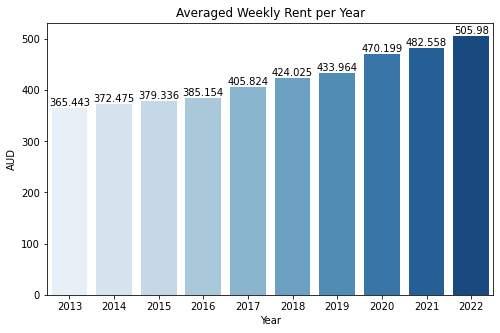

In [131]:
plt.figure(figsize=(8,5))
ranks = year_df.averaged_wk_rent.rank().sub(1).astype(int).array
palette = sns.color_palette('Blues', len(ranks))
ax = sns.barplot(
    data=year_df, x="year", y="averaged_wk_rent", palette=np.array(palette)[ranks]
)
#for i in range(len(ax.containers)):
#    ax.containers[i] = str(int(ax.containers[i]) / 1000 )+'k'
#show_values(ax)
ax.bar_label(ax.containers[0])
ax.set(title = "Averaged Weekly Rent per Year", ylabel = "AUD", xlabel = "Year")
plt.savefig("../../plots/figure/Averaged Weekly Rent per Year.jpg")

In [133]:
import shutil
historical_path = '../../data/curated/historical'
property_all_path = newpath
shutil.rmtree(historical_path)
shutil.rmtree(property_all_path)